In [369]:
import numpy as np
import camb
from matplotlib import pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,7)

# Part 1: $\chi^2$

Using the sample scrip provided and the parameters set to:

$$H_0 = 60$$
$$\Omega_bh^2 = 0.02$$
$$\Omega_ch^2 = 0.1$$
$$\tau = 0.05$$
$$A_s = 2 \times 10^{-9}$$
$$n_s = 1.0$$

We get $\chi ^2 = 15267.9$, given that we have $dof = 2501$ degrees of freedom. We expect the $\chi^2$ of a good fit to be close to the number of degrees of freedom. In this case, it is much larger so I would say that these test parameters do not provide an acceptable fit.

Now, if we instead use values that we know are closer to the actual accepted values of these parameters:

$$H_0 = 69$$
$$\Omega_bh^2 = 0.022$$
$$\Omega_ch^2 = 0.12$$
$$\tau = 0.06$$
$$A_s = 2.1 \times 10^{-9}$$
$$n_s = 0.95$$

We end up with a value of $\chi ^2 = 3272.2$. Even though this is still not equal to the number of degrees of freedom, it is a lot closer and has the same order of magnitude. Based on that, I would consider these parameters to produce an acceptable fit. We also see this reflected in the graphs, where now the model follows the data points a lot closer. 

In [410]:
def get_spectrum(pars,lmax=3000):
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    
    
    return tt[2:][:2507]

In [411]:
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);

chisq is  15267.937968222595  for  2501  degrees of freedom.


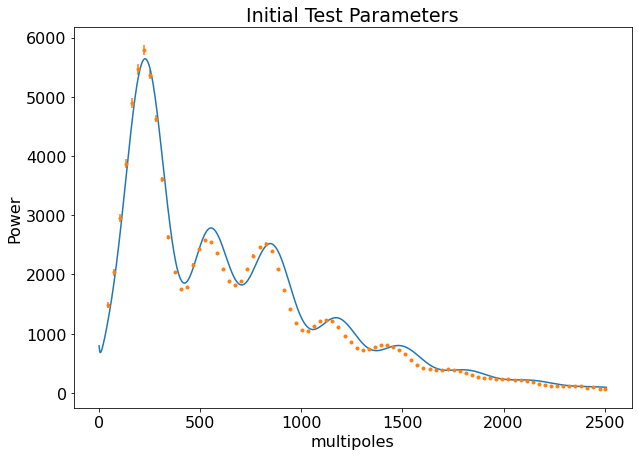

In [412]:
pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])

model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")

plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.title('Initial Test Parameters')
plt.xlabel('multipoles')
plt.ylabel('Power')
plt.show()

chisq is  3272.2033778089576  for  2501  degrees of freedom.


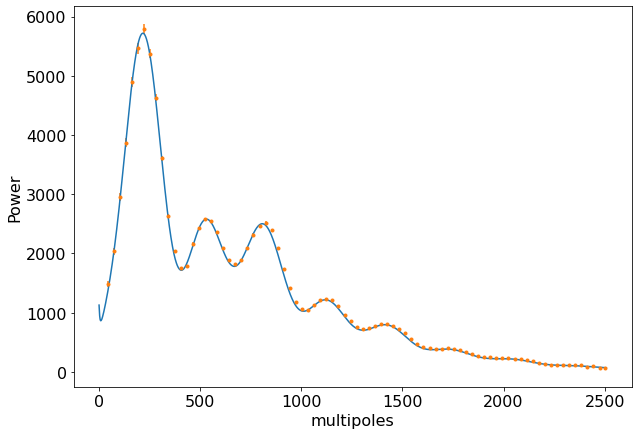

In [413]:
pars2 = [69, 0.022, 0.12, 0.06, 2.1e-9, 0.95]

model=get_spectrum(pars2)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars2)," degrees of freedom.")

plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.xlabel('multipoles')
plt.ylabel('Power')
plt.show()

# Part 2: Newton's Best-Fit Parameters

Using Newton's method to fit for the parameters, the results with their respective errors were:

$$H_0 = 68.23 \pm 1.19$$
$$\Omega_bh^2 = 0.02236 \pm 0.00023$$
$$\Omega_ch^2 = 0.1177 \pm 0.0027$$
$$\tau = 0.085 \pm 0.034$$
$$A_s = 2.21 \times 10^{-9} \pm 1.43 \times 10^{-10}$$
$$n_s = 0.973 \pm 0.007$$

These results have also been saved in the text file planck_fit_params.txt.

We see that the optical depth has a high fractional error. We are using intensity data which does a poor job at constraining the optical depth so it makes sense that fitting a model to this data isn't able to precisely determine the optical optical depth.

Regardless of that, we have a $\chi^2 = 2576.15$, which is very close to the $dof = 2501$, meaning we managed to properly fit the data (with the given uncertainties) even without a precise value for $\tau$.

In [587]:
def num_derivs(fun,pars,dp,ell):
    A=np.empty([len(ell),len(pars)])
    for i in range(len(pars)):
        pp=pars.copy()
        pp[i]=pars[i]+dp[i]
        y_right = fun(pp)
        pp[i]=pars[i]-dp[i]
        y_left=fun(pp)
        A[:,i]=(y_right-y_left)/(2*dp[i])
    return A

# getting N inverse analitically with data errors
Ninv = np.diag(1 / errs**2)

def newton(pars, data, fun, dpar, ell, niter=15):
    '''performs the nonlinear fit using newtons method'''
    
    for i in range(niter):
        model = fun(pars)
        derivs = num_derivs(fun, pars, dpar, ell)  
        
        r = data - model
        
        lhs = derivs.T @ Ninv @ derivs
        lhs_inv = np.linalg.inv(lhs)
        
        rhs = derivs.T @ Ninv @ r
        dp = lhs_inv @ rhs
        pars = pars + dp
        print(f'Parameter Shift is ', dp)
        print()
    
    # errors in parameters
    var = lhs_inv
    err_params = np.sqrt((np.diag(var)))
    
    #with open('./planck_fit_params.txt', 'w') as f:
        #for i, el in enumerate(pars):
            #f.write(str(el) + ' ' + str(err_params[i]))
            #f.write('\n')
    #f.close()
    
    return pars, err_params, var

In [588]:
pars2 = [60, 0.02, 0.11, 0.04, 2.0e-9, 1.0]
dpar = np.asarray([0.1, 0.0001, 0.001, 0.001, 1e-10, 0.001])

In [589]:
fitp, errp, var = newton(pars2, spec, get_spectrum, dpar, ell, niter=15)

Parameter Shift is  [ 2.21446595e+00  1.21784212e-03  1.60610338e-02  5.58041528e-01
  2.28938104e-09 -4.86983612e-02]

Parameter Shift is  [ 1.29381711e+01  2.50189031e-03 -2.09999897e-02 -3.68474590e-01
 -1.29881001e-09  3.64449097e-02]

Parameter Shift is  [-7.42114299e+00 -1.39908888e-03  1.27490960e-02 -1.40262327e-01
 -8.60522566e-10 -2.05974768e-02]

Parameter Shift is  [ 4.65693701e-01  3.25962849e-05 -3.24016375e-05 -6.40841306e-03
  7.98036737e-11  5.88676237e-03]

Parameter Shift is  [ 5.31205040e-02  1.15218893e-05 -1.27597813e-04  2.81607038e-03
  1.05956983e-11  5.32365929e-05]

Parameter Shift is  [-2.33717200e-02 -3.00631011e-06  5.14545023e-05 -9.72696852e-04
 -4.00108831e-12 -1.20745111e-04]

Parameter Shift is  [ 4.13387387e-03  5.05038983e-07 -9.35022547e-06  2.26665005e-04
  9.51468795e-13  2.24898383e-05]

Parameter Shift is  [-3.98987564e-04 -4.27524236e-08  9.14629158e-07  5.04060225e-06
  2.69470813e-14 -1.63773831e-06]

Parameter Shift is  [-2.19764268e-05 -2.

chisq is  2576.1522936743595  for  2501  degrees of freedom.


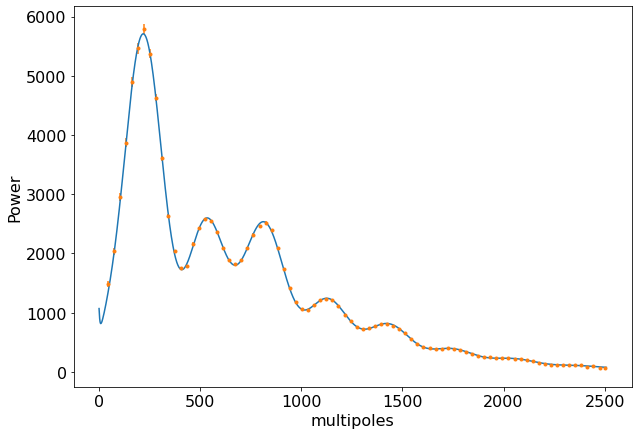

In [480]:
mymod = get_spectrum(fitp)
resid = spec-mymod
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(fitp)," degrees of freedom.")

plt.clf()
plt.plot(ell,mymod)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.xlabel('multipoles')
plt.ylabel('Power')
plt.show()

In [481]:
print('params =', fitp)
print()
print('errs =', errp)

params = [6.82309736e+01 2.23622595e-02 1.17692499e-01 8.49759231e-02
 2.21744220e-09 9.72990653e-01]

errs = [1.18850917e+00 2.29286127e-04 2.65829239e-03 3.41133594e-02
 1.43183353e-10 6.58142904e-03]


# Part 3: MCMC sampler 

Now we perform the fit using a Markov chain Monte Carlo. For this, we start with a guess of the parameters and estimate the $\chi^2$ value using the model created by those parameters. Then, from the covariance matrix estimated using Newton's method, we take steps within that curvature to sample the relevant portions of parameter space. We record every step of the chain in planck_chain.txt with each column representing ($\chi^2$, $H_0$, $\Omega_bh^2$, $\Omega_ch^2$, $\tau$, $A_s$, $n_s$).

I ran the chain for 5000 steps. And looked at the results, from which I determined there was about 1000 samples in the burn-in and the rest of the chains looked converged. Just in case, I took the first 2000 samples off the data when using it to estimate the mean value of each parameter. In the first plot below, I show how each of the parameters varied through the duration of the chain. It is clear that the one that varied the most was $\tau$, which did not surprise me for the reasons mentioned in Part 2.

Looking at the fourier transform, we see that in fact all of our parameters have converged as we see a flat signal on the lower k values in fourier space. From these conclusions, I estimated the mean value of our parameters to be:

$$H_0 = 68.18 \pm 1.21$$
$$\Omega_bh^2 = 0.02236 \pm 0.00024$$
$$\Omega_ch^2 = 0.1179 \pm 0.0027$$
$$\tau = 0.086 \pm 0.028$$
$$A_s = 2.22 \times 10^{-9} \pm 1.18 \times 10^{-10}$$
$$n_s = 0.973 \pm 0.007$$

Now, for the estimate of the dark energy density parameter, I used the fact that $\Omega_{\Lambda} = 1 - \frac{\Omega_bh^2}{h^2} - \frac{\Omega_ch^2}{h^2}$ and $h = \frac{H_0}{100}$. Using the mean values found for those, I got the result that:

$$\Omega_{\Lambda} = 0.698$$

I believe the accepted value is around $73\%$. So this is close, but not fully consistent. 




In [430]:
def chisq_fun(fun, params, data, errs):
    '''estimates chi squared value'''
    
    pred = fun(params)
    pred = pred[:len(data)]
    resid = data - pred
    chisq = np.sum((resid/errs)**2)
        
    return chisq

In [586]:
def writing(chisq, pars, filename):
    '''appends new rows to an existing txt file'''
    with open(filename, 'a') as f:
        f.write('\n')
        warray = np.append(chisq, pars)
        for el in warray: 
            f.write(str(el) + ' ')
    f.close()
    return None

In [435]:
pars3 = [69, 0.022, 0.12, 0.06, 2.1e-9, 0.95]

In [438]:
nsteps = 5000

# initializing chain
chain = np.zeros([nsteps, len(pars3)])

# start position
chain[0,:] = pars3

# start chi squared
chisq = chisq_fun(get_spectrum, chain[0,:], spec, errs)

with open('./planck_chain2.txt', 'w') as f:
    warray = np.append(chisq, pars3)
    for el in warray:  
        f.write(str(el) + ' ')
f.close()
    
for i in range(1, nsteps):
    # take trial step from errors of gaussian approximation
    pp = chain[i-1,:] + np.random.multivariate_normal(np.zeros(len(var)), var)
    chisq2 = chisq_fun(get_spectrum, pp, spec, errs)
    
    '''writing text file'''
    _ = writing(chisq2, pp, './planck_chain2.txt')
    '''done writing text file'''
    
    accept = np.exp(-0.5 * (chisq2 - chisq))
    if np.random.rand(1) < accept:
        chain[i,:] = pp
        chisq = chisq2
    else:
        chain[i,:] = chain[i-1,:]
        
f.close()

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_

In [439]:
# chop off some part of it until converged - burn-in
burnin = 2000
best_fit_MC = np.mean(chain[burnin:], axis=0)

# estimate errors on parameters from mcmc
errs_fit = np.std(chain[burnin:], axis=0)

In [493]:
pars_name = ['$H_0$', '$\Omega_bh^2$','$\Omega_ch^2$','$t$','$A_s$','$n_s$']

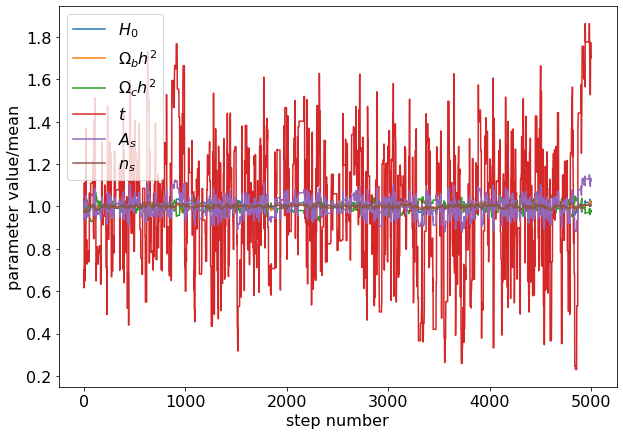

In [494]:
for i in range(len(best_fit_MC)):
    plt.plot(chain[:,i]/best_fit_MC[i], label=pars_name[i])

plt.ylabel('parameter value/mean')
plt.xlabel('step number')
plt.legend()
plt.show()

In [496]:
print(best_fit_MC)
print(errs_fit)
h2 = (best_fit_MC[0]/100)**2
Omega_A = 1 - best_fit_MC[1]/h2 - best_fit_MC[2]/h2
print()
print(Omega_A)

[6.81839045e+01 2.23613438e-02 1.17855264e-01 8.57070891e-02
 2.22449655e-09 9.73031105e-01]
[1.20714010e+00 2.41770245e-04 2.73149769e-03 2.80117108e-02
 1.17515734e-10 6.76904678e-03]

0.6983969554232043


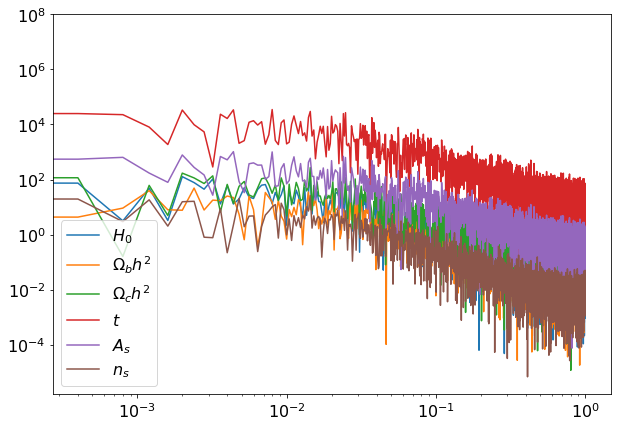

In [498]:
for i in range(len(pars3)):
    psd = np.abs(np.fft.rfft(chain[:,i]))**2 / (np.mean(chain[:,i])**2)
    plt.loglog(np.linspace(0,1,len(psd)),psd, label=pars_name[i])
plt.legend()
plt.show()

# Part 4: $\tau$ Constraint and Importance Sampling

Using polarization data, we are able to constraint the value of $\tau$, for which we get a new prior: $\tau = 0.0540 \pm 0.0074$. I ran a new chain including this constraint to get a better estimate for $\tau$ using our data. To do this, I estimated the $\Delta \chi^2$ at each step of the chain using:

$$\Delta \chi^2 = \frac{(\tau_{data} - \tau_{mean})^2}{\sigma^2}$$

Where $\tau_{mean} = 0.0540$ and $\sigma = 0.0074$. We see that if the value for $\tau_{data}$ (the tau estimated at that step of the markov chain is close to the mean value, this $\Delta \chi^2$ will be very small. The further it gets from this mean, it will grow larger. Then, we add this $\Delta \chi^2$ to the $\chi^2$ estimated for the model using the calculated parameters. Again, if the $\Delta \chi^2$ was large, this significantly decreases the probability that the new parameters will be accepted by the chain. Using this method, the new estimate for the parameters were:

$$H_0 = 67.79 \pm 0.85$$
$$\Omega_bh^2 = 0.02229 \pm 0.00017$$
$$\Omega_ch^2 = 0.1186 \pm 0.0019$$
$$\tau = 0.056 \pm 0.007$$
$$A_s = 2.10 \times 10^{-9} \pm 0.029 \times 10^{-9}$$
$$n_s = 0.971 \pm 0.005$$

We see that the new estimated $\tau$ lies within the range given by the prior.

### Importance Sampling

Now we compare this method with what we would have got by using importance sampling. For this, I used the weights:

$$w = e^{-\frac{1}{2}\Delta\chi^2}$$

With the same formula for $\Delta\chi^2$ as shown above. I read in the tau values at each step of the first (unconstrained) chain I ran and then took a weighted average using $w$. The resulting $\tau$ value was:

$$\tau = 0.05458$$

This value is centaintly consistent with the prior we had within it's uncertainties. In addition, it is good to note that while rerunning the chain required significant computational power, importance sampling accomplished the same result with very little extra input after the running of the original chain. 

### Rerunning the chain with the $\chi^2$ constraint

In [500]:
def delta_chi2_fun(tau):
    tau_mean = 0.0540 
    tau_err = 0.0074
    
    delta_chisq = (tau - tau_mean)**2/tau_err**2
    
    return delta_chisq

In [502]:
nsteps = 5000

# initializing chain
chain = np.zeros([nsteps, len(pars3)])

# start position
chain[0,:] = pars3

# start chi squared
chisq = chisq_fun(get_spectrum, chain[0,:], spec, errs)

with open('./planck_chain_tauprior.txt', 'w') as f:
    warray = np.append(chisq, pars3)
    for el in warray:  
        f.write(str(el) + ' ')
f.close()
    
for i in range(1, nsteps):
    # take trial step from errors of gaussian approximation
    pp = chain[i-1,:] + np.random.multivariate_normal(np.zeros(len(var)), var)
    chisq2 = chisq_fun(get_spectrum, pp, spec, errs)
    delta_chisq = delta_chi2_fun(pp[3])
    chisqnew = chisq2 + delta_chisq
    
    '''writing text file'''
    _ = writing(chisqnew, pp, './planck_chain_tauprior.txt')
    '''done writing text file'''
    
    accept = np.exp(-0.5 * (chisqnew - chisq))
    if np.random.rand(1) < accept:
        chain[i,:] = pp
        chisq = chisqnew
    else:
        chain[i,:] = chain[i-1,:]
        
f.close()

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_

In [503]:
# chop off some part of it until converged - burn-in
burnin = 2000
MC_tau = np.mean(chain[burnin:], axis=0)

# estimate errors on parameters from mcmc
errs_fit_tau = np.std(chain[burnin:], axis=0)

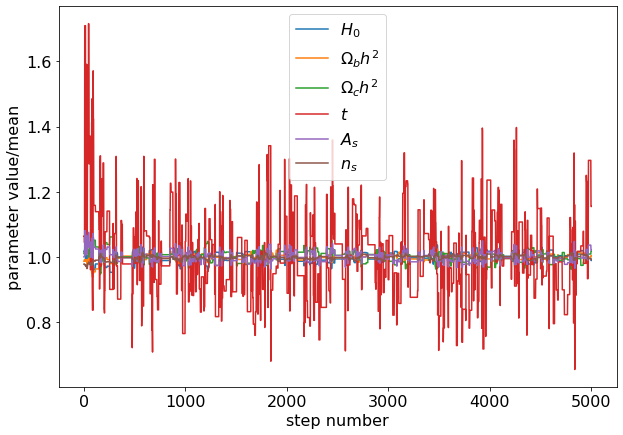

In [504]:
for i in range(len(MC_tau)):
    plt.plot(chain[:,i]/MC_tau[i], label=pars_name[i])

plt.ylabel('parameter value/mean')
plt.xlabel('step number')
plt.legend()
plt.show()

In [506]:
print(MC_tau)
print(errs_fit_tau)
h2 = (MC_tau[0]/100)**2
Omega_A_tau = 1 - MC_tau[1]/h2 - MC_tau[2]/h2
print()
print(Omega_A_tau)

[6.77925052e+01 2.22916763e-02 1.18643009e-01 5.64005679e-02
 2.09890759e-09 9.71064368e-01]
[8.54071602e-01 1.70443090e-04 1.91516890e-03 6.89266303e-03
 2.93904163e-11 5.04402637e-03]

0.6933418426482443


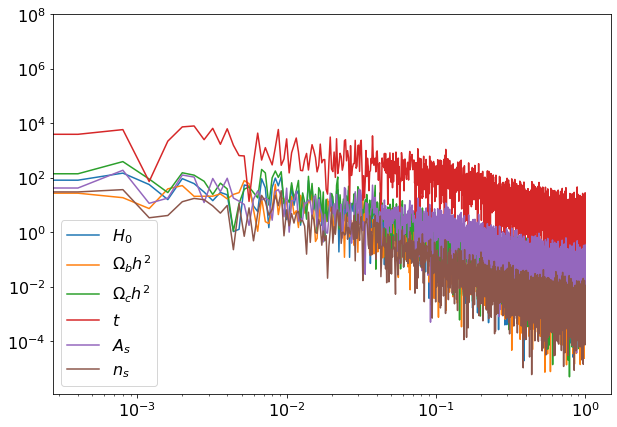

In [507]:
for i in range(len(pars3)):
    psd = np.abs(np.fft.rfft(chain[:,i]))**2 / (np.mean(chain[:,i])**2)
    plt.loglog(np.linspace(0,1,len(psd)),psd, label=pars_name[i])
plt.legend()
plt.show()

### Doing the same thing with importance sampling

In [519]:
def weights(tau):
    
    w = np.exp(-0.5*delta_chi2_fun(tau))
    
    return w

In [572]:
# reading in data from first chain

chain_og = np.loadtxt('./planck_chain.txt')
tau_og = chain_og[:,4]

In [573]:
w = weights(tau_og)

In [577]:
new_tau = np.average(tau_og, weights=w)
print(new_tau)

0.054578385254717664
